# Transverse feedback

In [1]:
# %reset -f
import numpy as np

import matplotlib.pyplot as plt
import scipy
import scipy.stats as st
import scipy.special as spec
import matplotlib as mpl
from matplotlib.colors import LogNorm
import matplotlib.cm as cm
import scipy.integrate as integrate

import pickle as pkl


# Plotting preparation
import sys
sys.path.append('../')
from plot_configuration import *
np.set_printoptions(precision=3,suppress=True) 
from mpl_toolkits.axes_grid1.inset_locator import inset_axes,mark_inset
plt.close('all')

Finished configuring the plots.


In [2]:
pi2=np.pi*2
%matplotlib notebook
dir_save = '01_Output/'
pltdir = '03_Plots'

<IPython.core.display.Javascript object>


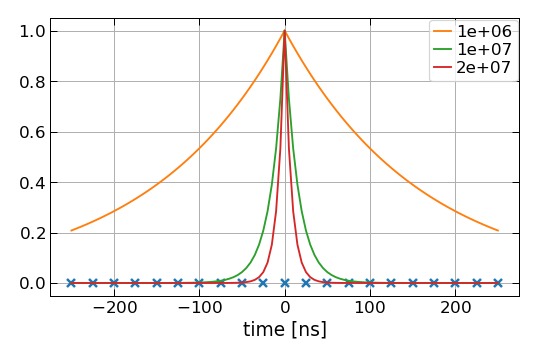

<IPython.core.display.Javascript object>


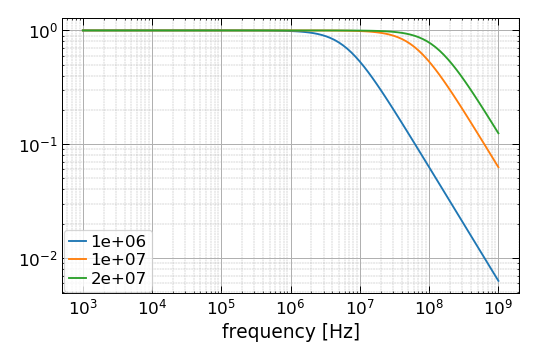

/home/sfuruset/miniconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:1238: UserWarning: findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))
/home/sfuruset/miniconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:1238: UserWarning: findfont: Font family ['Bitstream Vera Sans'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


In [3]:
dt = 25e-9

t_bunch = np.arange(-10,11)*dt
ts = np.linspace(-10*dt,10*dt,101)
freq = np.logspace(3,9,100)
fco = np.array([1e3,1e4,1e5,1e6,1e7,2e7])
wco = fco*2*np.pi

fig1,ax1=plt.subplots(1)
fig2,ax2=plt.subplots(1)
ax1.plot(t_bunch*1e9,0*t_bunch,'x')
for i in range(3,6):
    label="%.0e"%fco[i]
    ax1.plot(ts*1e9,np.exp(-wco[i]*np.abs(ts)),label=label)
    ax2.loglog(freq,np.abs(1j*wco[i]/(1j*freq+wco[i])),label=label)

for iax,ax in enumerate([ax1,ax2]):
    ax.legend()
    ax.set_xlabel([r'time [ns]',r'frequency [Hz]'][iax])
    ax.grid(1,which='major')
    ax.grid(1,which='minor',ls='--',lw=0.4)
    fig=[fig1,fig2][iax]
    fig.tight_layout()
    

# Low BW weighting

In [4]:
np.log(0.113458834)


-2.176315203886037

In [5]:
np.sinc(1)
np.heaviside(2,3)

1.0

[-9 -8 -7 -6 -5 -4 -3 -2 -1  0  1  2  3  4  5  6  7  8  9]
5.449220020208022 -2.7861025885745966e-05 (0.9999999999987663-1.5707963267942506e-06j)
5.449220020208023 5.449220020208022
5.449199777987844 5.449199777987842
5.449134272787326 5.449134272787324
5.44930576762872 5.4493057676287195
5.449240262428203 5.4492402624282015
5.449220020208023 5.449220020208022
5.449199777987844 5.449199777987843
5.449134272787325 5.449134272787325
5.44930576762872 5.4493057676287195
5.449240262428203 5.4492402624282015


<IPython.core.display.Javascript object>


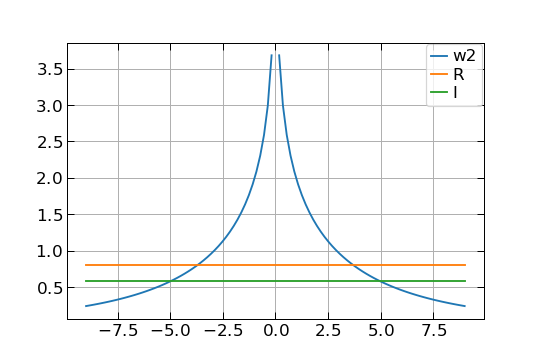

[5.449-0.j    5.449-0.j    5.449-0.j    5.449-0.j    5.449-0.j
 5.449-0.001j 5.449-0.01j  5.448-0.074j 5.399-0.569j 3.055-3.033j]


In [6]:
fco = 1e6
wco = fco*2*np.pi
dt = 25e-9

fc = 1e1
wc = fc*2*np.pi
phi0 = np.pi*.4

def weight(b,wco=wco,dt=dt,mode=0):
    if mode==0:
        ans = np.array(np.exp(-wco*dt*b))
        ans[b<0] = 0
        return ans
#         return np.exp(-wco*dt*np.abs(b))*(1+1*(b==0))/2
    elif mode==1:
        return spec.k0(wco*dt*np.abs(b))#/spec.k0(0)
    elif mode==2:
        return np.exp(-(wco*dt*b)**2)
    elif mode==3:
        return np.exp(-np.abs(b)*wco*dt)
    elif mode ==4:
        return np.sinc(b*dt*wco/np.pi)
    
    
def transfer_function(w,wco,dt,mode=0):
    
    if mode == 0:
        return 1/(1+1j*w/wco)
    
    elif mode==3:
        return 2/(1 + (w/wco)**2)
    elif mode ==4:
        ans = np.pi*np.ones_like(w)
        ans[w>wco]=0
        return ans
    else: 
        return np.nan
    
def phase(b,wc=wc,dt=dt):
    return np.exp(-1j*(wc*dt*b))



bmax= 10
b = np.arange(-bmax+1,bmax,1)
print(b)
bi = np.linspace(-bmax+1,bmax-1,101)

weights = weight(b)
func = (-1+(1-weight( bmax)*phase( bmax))/(1-weight( 1)*phase( 1))
                         +(1-weight(-bmax)*phase(-bmax))/(1-weight(-1)*phase(-1)))

print(func.real,func.imag,phase(1))
for i in range(10):
    phi0 = 2*np.pi*i/10
    phase0 = np.exp(-1j*phi0)
    phases = phase(b) * phase0
    sumall    =phase0*func
    print(np.real(np.sum(weights*phases/np.real(phase0))),np.real(sumall)/np.real(phase0) ) #,np.real(sumphases))

# sumweights= -1+2*np.sum(weights)
# print(sumweights)
# sumphases = -1+2*phase0*(1-phase(bmax))/(1-phase(1))


plt.figure()
# plt.plot(bi,weight(bi),label='w')
plt.plot(bi,weight(bi,mode=1),label='w2')
plt.plot(b,phases.real,label='R')
plt.plot(b,phases.imag,label='I')
plt.legend(loc=0)
plt.grid(True)

wcs = np.logspace(-1,7,10)
funcs = (-1+(1-weight( bmax)*phase( bmax,wc=wcs))/(1-weight( 1)*phase( 1,wc=wcs))
                  +(1-weight(-bmax)*phase(-bmax,wc=wcs))/(1-weight(-1)*phase(-1,wc=wcs)))
print(funcs)


# Weight file

In [27]:
Ncol = 34
Nrow = 20+1
fcos = 1e6*np.arange(1,Nrow)
dt = 25e-9 #ns
t = np.arange(Ncol-1)*dt
print(t*1e9)

weight_array = np.zeros((Ncol,Nrow))
weight_array[1:,0] = t*1e9
weight_array[0,1:] = fcos
for i,fco in enumerate(fcos):
    weight_array[1:,1+i] = np.exp(-pi2*fco*t)

print(weight_array)
np.savetxt('LBWfeedback_weight_exp.dat',weight_array)

[  0.  25.  50.  75. 100. 125. 150. 175. 200. 225. 250. 275. 300. 325.
 350. 375. 400. 425. 450. 475. 500. 525. 550. 575. 600. 625. 650. 675.
 700. 725. 750. 775. 800.]
[[       0.     1000000.     2000000.     3000000.     4000000.
   5000000.     6000000.     7000000.     8000000.     9000000.
  10000000.    11000000.    12000000.    13000000.    14000000.
  15000000.    16000000.    17000000.    18000000.    19000000.
  20000000.   ]
 [       0.           1.           1.           1.           1.
         1.           1.           1.           1.           1.
         1.           1.           1.           1.           1.
         1.           1.           1.           1.           1.
         1.   ]
 [      25.           0.855        0.73         0.624        0.533
         0.456        0.39         0.333        0.285        0.243
         0.208        0.178        0.152        0.13         0.111
         0.095        0.081        0.069        0.059        0.051
         0.043]
 [ 

In [52]:
# int binarySearch(double* array,const int& size,const double& value,int lower,int upper,int& nStep) {
def binarySearch(array,size,value, lower, upper, nStep):
    pivot = int((lower+upper)/2);
    if((upper-lower)<=1):
        return lower;
    if(value < array[pivot]):
        upper = pivot;
        pivot = int((lower+upper)/2);
        nStep+=1;
        return binarySearch(array,size,value,lower,upper,nStep);
    elif(value > array[pivot]):
        lower = pivot;
        pivot = (lower+upper)/2;
        nStep+=1;
        return binarySearch(array,size,value,lower,upper,nStep);
    else:
        return pivot;
    

array = np.arange(10)
upper = size=10
lower = nStep = 0
value =11
print(binarySearch(array,size,value, lower, upper, nStep))

9


# Response functions 

In [59]:
1/(2*dt)

20000000.0

<IPython.core.display.Javascript object>


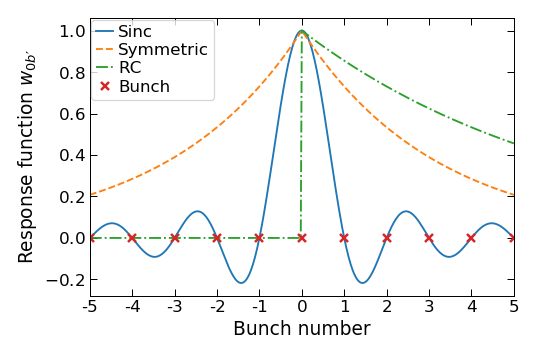

<IPython.core.display.Javascript object>


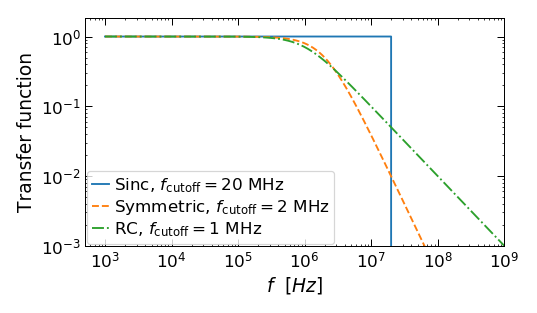

[-5.    -4.975 -4.95  -4.925 -4.9   -4.875 -4.85  -4.825 -4.8   -4.775
 -4.75  -4.725 -4.7   -4.675 -4.65  -4.625 -4.6   -4.575 -4.55  -4.525
 -4.5   -4.475 -4.45  -4.425 -4.4   -4.375 -4.35  -4.325 -4.3   -4.275
 -4.25  -4.225 -4.2   -4.175 -4.15  -4.125 -4.1   -4.075 -4.05  -4.025
 -4.    -3.975 -3.95  -3.925 -3.9   -3.875 -3.85  -3.825 -3.8   -3.775
 -3.75  -3.725 -3.7   -3.675 -3.65  -3.625 -3.6   -3.575 -3.55  -3.525
 -3.5   -3.475 -3.45  -3.425 -3.4   -3.375 -3.35  -3.325 -3.3   -3.275
 -3.25  -3.225 -3.2   -3.175 -3.15  -3.125 -3.1   -3.075 -3.05  -3.025
 -3.    -2.975 -2.95  -2.925 -2.9   -2.875 -2.85  -2.825 -2.8   -2.775
 -2.75  -2.725 -2.7   -2.675 -2.65  -2.625 -2.6   -2.575 -2.55  -2.525
 -2.5   -2.475 -2.45  -2.425 -2.4   -2.375 -2.35  -2.325 -2.3   -2.275
 -2.25  -2.225 -2.2   -2.175 -2.15  -2.125 -2.1   -2.075 -2.05  -2.025
 -2.    -1.975 -1.95  -1.925 -1.9   -1.875 -1.85  -1.825 -1.8   -1.775
 -1.75  -1.725 -1.7   -1.675 -1.65  -1.625 -1.6   -1.575 -1.55  -1.525
 -1.5 

/home/sfuruset/miniconda3/lib/python3.5/site-packages/matplotlib/axes/_base.py:3364: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=1.0, top=1.0
  self.set_ylim(upper, lower, auto=None)


In [136]:
dt = 25e-9

bwidth = 5
t_bunch = np.arange(-bwidth,bwidth+1)*dt
ts = np.linspace(-bwidth*dt,bwidth*dt,401)
freq = np.logspace(3,9,400)
w    = freq*2*np.pi
fco = 1e6
wco = fco*2*np.pi

fig1,ax1=plt.subplots(1)
fig2,ax2=plt.subplots(1,figsize=(figwidth,3.5))

bs = ts/dt
print(bs)
for i,mode in enumerate([4,3,0]):
    label="mode %d"%i
    label = ['Sinc','Symmetric','RC'][i]
    ls = ['-','--','-.'][i]
    
    wco = 2*np.pi * [2e7,2e6,1e6,][i]
    
    weights = weight(bs,wco=wco,dt=dt,mode=mode)
    ax1.plot(ts*1e9,weights,ls=ls,label=label)
    
    
    transfer = np.abs(transfer_function(w,wco,dt,mode=mode))
    if np.size(transfer)>1:
        ax2.loglog(freq,transfer/transfer[0],ls=ls,label=label + r', $f_\mathrm{cutoff}=%.0f$ MHz'%(wco/pi2*1e-6))
ax1.plot(t_bunch*1e9,0*t_bunch,'x',label='Bunch')

ax1.set_xlim(-100,100)
ax1.set_xticks(t_bunch*1e9)
ax1.set_xticklabels(np.int32(t_bunch/dt))
ax1.legend(loc=2)
ax1.set_xlabel(r'$t$ [ns]')
ax1.set_xlabel(r'Bunch number')
ax1.set_ylabel(r"Response function $w_{0b\prime}$")
fig1.tight_layout()
fig1.savefig(pltdir+'/responseFunction.eps')


ax2.set_xlabel(r'$f$  $[Hz]$')
ax2.set_ylabel(r'Transfer function')
ax2.legend(loc=0)
ax2.set_ylim(bottom=1e-3)
ax2.set_xlim(right=1e9)
fig2.tight_layout()
fig2.savefig(pltdir+'/transferFunction.eps')

# for iax,ax in enumerate([ax1,ax2]):
#     ax.legend()
#     ax.set_xlabel([r'time [ns]',r'frequency [Hz]'][iax])
#     ax.grid(1,which='major')
#     ax.grid(1,which='minor',ls='--',lw=0.4)
#     fig=[fig1,fig2][iax]
#     fig.tight_layout()
    

<IPython.core.display.Javascript object>


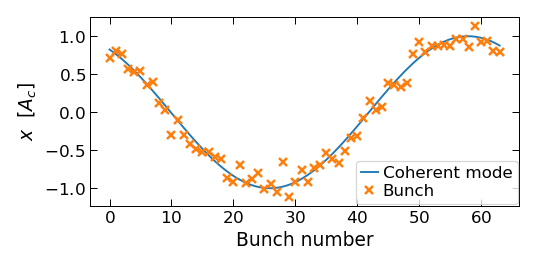

In [122]:
# bunch motion

plt.figure(figsize=(figwidth,3))
As = 1
sig_inc = 0.1
NB=64
bsi=np.linspace(0,NB-1,100)
bs = np.arange(NB)
dt = 25e-9
fc = 1e5
wc = 2*np.pi*fc

M = NB
m = 1

phi0 = np.random.uniform(0,pi2)*0+0.6

Xc = As*np.cos(bsi*pi2 * m/M + phi0) 
xc = As*np.cos(bs*pi2 * m/M + phi0) 
xi = np.random.normal(0,sig_inc,NB)

plt.plot(bsi,Xc,label='Coherent mode')
plt.plot(xc+xi,'x',label='Bunch')

plt.xlabel('Bunch number')
plt.ylabel(r'$x$  $[A_c]$')
plt.legend(loc=0)
plt.tight_layout()
plt.savefig(pltdir+'/beamOscillation.eps')

# plt.ylim(bottom=-As*1.1,top=As*1.1)

# Effective Number of Kicks

In [7]:
import sys
sys.path.append('../01_DistributionDiffusion/')
from LebedevHelper import *


In [16]:
mode=3
fcoLF = 1e1
wcoLF = fcoLF*pi2
fco = 1e5
wco = pi2*fco
dt = 25e-9
Nbunches=16*4

bs = np.arange(Nbunches)+1
NtildeLF = np.zeros(Nbunches)
NtildeHF = np.zeros(Nbunches)
NtildeBPM= np.zeros(Nbunches)
for i,ib in enumerate(bs):
    weights = weight(ib-bs,wco=wco,dt=dt,mode=mode)
    ACLF = weight(ib-bs,wco=wcoLF,dt=dt,mode=mode)*0+1
    ACBPM= weights
    NtildeLF[i] = np.sum(weights*ACLF)
    NtildeHF[i] = 1#weights[ib]
    NtildeBPM[i]= np.sum(weights*ACBPM)

# NtildeBPM = NtildeLF**0.5
Ntilde = NtildeLF
print(weights)
print(NtildeLF)
print(NtildeBPM)
print(np.max(NtildeLF))


#########################
### Lebedev reduction ###
dq=1
leb_red = 0.4 #from lebedev_trends
sigma_LF=1e-2   *0
sigma_HF = 1e-3 *1 
sigma_BPM=1e-2  *0
corr = 1

a = 1e-3
b = -0.7*a
g = 1e-2

facLF = np.zeros_like(NtildeLF)
facHF = np.zeros_like(NtildeLF)
facBPM= np.zeros_like(NtildeLF)

for i in range(Nbunches):
    facLF[i] = integrate.nquad(int_octu_leb, [[0,np.inf], [0,np.inf]],args=(a,b,g*(NtildeLF[i])))[0]
    facBPM[i]= integrate.nquad(int_octu_leb, [[0,np.inf], [0,np.inf]],args=(a,b,g*(NtildeBPM[i])))[0]    
#     facHF[i] = integrate.nquad(int_octu_leb, [[0,np.inf], [0,np.inf]],args=(a,b,g*(NtildeHF[i])))[0]
fac2= facLF
facHF[:]=integrate.nquad(int_octu_leb, [[0,np.inf], [0,np.inf]],args=(a,b,g))[0]    
    
# print(fac2)

print(facLF)
print(facBPM)
print(facHF)

[0.372 0.378 0.384 0.39  0.396 0.402 0.408 0.415 0.421 0.428 0.435 0.442
 0.449 0.456 0.463 0.47  0.478 0.486 0.493 0.501 0.509 0.517 0.525 0.533
 0.542 0.551 0.559 0.568 0.577 0.586 0.595 0.605 0.614 0.624 0.634 0.644
 0.654 0.665 0.675 0.686 0.697 0.708 0.719 0.73  0.742 0.754 0.766 0.778
 0.79  0.803 0.815 0.828 0.841 0.855 0.868 0.882 0.896 0.91  0.924 0.939
 0.954 0.969 0.984 1.   ]
[40.684 41.297 41.888 42.458 43.008 43.537 44.045 44.532 44.999 45.446
 45.872 46.278 46.665 47.031 47.378 47.705 48.012 48.3   48.568 48.817
 49.046 49.256 49.447 49.619 49.771 49.904 50.019 50.114 50.19  50.247
 50.285 50.304 50.304 50.285 50.247 50.19  50.114 50.019 49.904 49.771
 49.619 49.447 49.256 49.046 48.817 48.568 48.3   48.012 47.705 47.378
 47.031 46.665 46.278 45.872 45.446 44.999 44.532 44.045 43.537 43.008
 42.458 41.888 41.297 40.684]
[28.004 28.835 29.631 30.394 31.124 31.822 32.489 33.125 33.73  34.306
 34.853 35.372 35.863 36.326 36.762 37.172 37.555 37.913 38.246 38.553
 38.835 39.

<IPython.core.display.Javascript object>


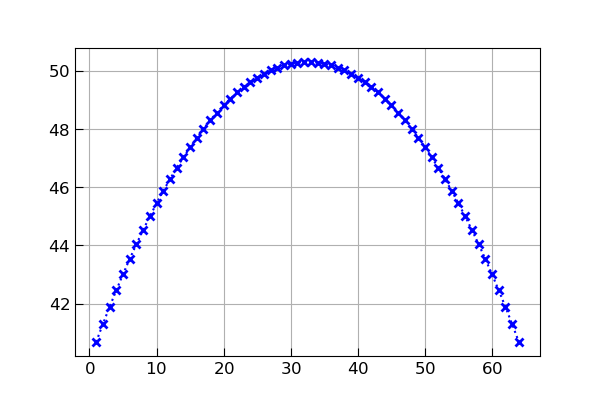

In [17]:
plt.figure()
plt.plot()
plt.plot(bs,NtildeLF,'bx:')
plt.grid(True)

In [9]:
print(sigma_LF,sigma_HF,sigma_BPM)

0.0 0.001 0.0


[8.45  8.485 8.515 8.54  8.562 8.581 8.597 8.611 8.622 8.632 8.641 8.648
 8.654 8.66  8.664 8.668 8.671 8.674 8.677 8.679 8.68  8.682 8.683 8.684
 8.685 8.686 8.686 8.687 8.687 8.687 8.688 8.688 8.688 8.688 8.687 8.687
 8.687 8.686 8.686 8.685 8.684 8.683 8.682 8.68  8.679 8.677 8.674 8.671
 8.668 8.664 8.66  8.654 8.648 8.641 8.632 8.622 8.611 8.597 8.581 8.562
 8.54  8.515 8.485 8.45 ]


<IPython.core.display.Javascript object>


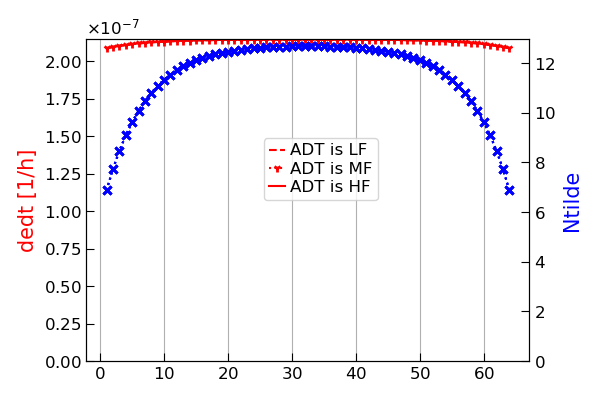

In [10]:
dedt = 0.4*0.5*(sigma_LF**2/(Ntilde)**2 + (sigma_HF**2 + g**2*Ntilde*sigma_BPM**2)*(1-g/2)**2/(1-g/2*(Ntilde-1)))

dedt = 0.5*(fac2*sigma_LF**2 + fac2[0]*(sigma_HF**2 + g**2*Ntilde*sigma_BPM**2)/(1-g/2*(Ntilde-1)))
# dedt = 0.5*(fac2*(sigma_LF**2 + g**2*Ntilde**1*sigma_BPM**2) + fac2[0]*(sigma_HF**2))

LFpart = 1
dedt1 = 0.5*(fac2*sigma_LF**2 + fac2[0]*sigma_HF**2 + (g**2*Ntilde*sigma_BPM**2)*(LFpart*fac2+(1-LFpart)*fac2[0]))
# dedt1 = 0.5*(fac2*sigma_LF**2 + fac2[0]*sigma_HF**2 + (g**2*sigma_BPM**2)*(LFpart*fac2*(Ntilde-1)+(1+1-LFpart)*fac2[0]))
dedt2 = 0.5*(fac2*sigma_LF**2 + fac2[0]*(sigma_HF**2 + g**2*Ntilde*sigma_BPM**2)/(1-g/2*(Ntilde-1)))

# dedt1= 0.5*(facLF * sigma_LF**2 + facHF*sigma_HF**2 + (g**2*NtildeLF*sigma_BPM**2)*(LFpart*facLF+(1-LFpart)*facHF))
dedt = 0.5*(facLF * sigma_LF**2 + facHF*sigma_HF**2 + facBPM*g**2*NtildeLF*sigma_BPM**2)
dedtLF = 0.5 * facLF * sigma_LF **2
dedtHF = 0.5 * facHF * sigma_HF **2 
varIM = sigma_HF**2/(2*g)
dedtIM = 0.5*facHF*varIM*g**2*(NtildeLF-1)

dedtADTisMF = 0.5*(facBPM*g**2*NtildeLF*sigma_BPM**2 )#  /(1-g/2*(NtildeLF-1)))
dedtADTisMF = 0.5*(facBPM*g**2*NtildeLF*sigma_BPM**2  /(1-g/2*(NtildeLF-1)))
dedtADTisLF = 0.5*(facLF*g**2*NtildeLF*sigma_BPM**2)
dedtADTisHF = 0.5*(facHF*g**2*NtildeLF*sigma_BPM**2/(1-g/2*(NtildeLF-1)))
dedtADTisEB = 0.5*facHF*g**2*sigma_BPM**2

dedt = dedtLF + dedtHF + dedtIM

print(dedt * 11245.5*3600)
plt.figure()
plt.gca().xaxis.grid(True)
ax1=plt.gca()
ax=ax1.twinx()

ax.set_ylabel('Ntilde',color='b')
ax.plot(bs,Ntilde,'bx:')
# ax.plot(bs,fac2*40,'orange')
# plt.plot(fac2)


timefac = 11245.5*3600
timefac = 1

# ax1.plot(bs,dedt* 11245.5*3600,'rx:')
ax1.plot(bs,(dedt+dedtADTisLF)* timefac,'r--',label='ADT is LF')
ax1.plot(bs,(dedt+dedtADTisMF)* timefac,'r1:',label='ADT is MF')
ax1.plot(bs,(dedt+dedtADTisHF)* timefac,'r-',label='ADT is HF')
# ax1.fill_between(bs,dedtADTisLF* 11245.5*3600,dedtADTisHF* 11245.5*3600,color='r',alpha=0.2)
ax1.set_ylabel('dedt [1/h]',color='r')

# ax1.set_yscale('log')
if sigma_LF==0 and sigma_HF==0:
    if fco==1e5: ax1.plot(bs,combi_fco1e5_suby* timefac,'kx',label='COMBI')
    if fco==1e6: ax1.plot(bs,combi_fco1e6_suby* timefac,'kx',label='COMBI')
elif sigma_HF==0:
    if fco==1e6: ax1.plot(bs,combi_fco1e6_LF_suby* timefac,'kx',label='COMBI')
# ax1.plot(bs,dedtADTisEB * 11245.5*3600,'r:',label='ADT EB')

ax1.legend(loc=(.4,.5))
for axi in [ax1,ax]:
    axi.set_ylim(bottom=0)
plt.tight_layout()

# ax1.grid(True,axis='x')


In [482]:
combi_fco1e5=np.array([3.62e-07,    3.28e-07,    3.63e-07,    3.84e-07,    3.62e-07,    3.41e-07,    2.74e-07,    3.05e-07,    2.62e-07,    2.46e-07,    1.96e-07,    2.14e-07,    2.80e-07,    3.01e-07,    2.34e-07,    1.96e-07,    2.49e-07,    2.52e-07,    2.25e-07,    2.31e-07,    1.91e-07,    1.61e-07,    1.39e-07,    1.95e-07,    2.09e-07,    2.34e-07,    2.27e-07,    3.15e-07,    2.24e-07,    2.04e-07,    1.99e-07,    2.05e-07,    2.04e-07,    1.92e-07,    2.61e-07,    1.95e-07,    1.32e-07,    2.37e-07,    2.48e-07,    2.27e-07,    2.02e-07,    2.71e-07,    2.54e-07,    2.25e-07,    2.30e-07,    1.86e-07,    2.72e-07,    2.11e-07,    2.39e-07,    2.49e-07,    3.47e-07,    1.92e-07,    2.34e-07,    2.43e-07,    3.79e-07,    3.33e-07,    3.02e-07,    3.53e-07,    2.47e-07,    2.92e-07,    3.04e-07,    3.10e-07,    3.85e-07,    3.18e-07])
combi_fco1e5_suby=np.array([4.41e-07,    3.75e-07,    3.48e-07,    4.30e-07,    4.10e-07,    3.76e-07,    3.10e-07,    3.55e-07,    2.82e-07,    2.76e-07,    2.12e-07,    2.45e-07,    3.17e-07,    3.22e-07,    2.61e-07,    2.15e-07,    2.76e-07,    2.85e-07,    2.57e-07,    2.47e-07,    2.08e-07,    1.99e-07,    1.71e-07,    2.11e-07,    2.41e-07,    2.83e-07,    2.47e-07,    3.50e-07,    2.61e-07,    2.46e-07,    2.37e-07,    2.34e-07,    2.20e-07,    2.22e-07,    2.84e-07,    2.16e-07,    1.66e-07,    2.65e-07,    2.70e-07,    2.69e-07,    2.31e-07,    2.97e-07,    2.71e-07,    2.62e-07,    2.70e-07,    2.22e-07,    2.95e-07,    2.58e-07,    2.62e-07,    2.81e-07,    3.59e-07,    2.21e-07,    2.82e-07,    2.79e-07,    3.93e-07,    3.47e-07,    3.40e-07,    3.69e-07,    2.60e-07,    3.31e-07,    3.42e-07,    3.42e-07,    4.15e-07,    3.79e-07])

combi_fco1e6_suby=np.array([ 6.56e-07,    7.86e-07,    6.27e-07,    7.63e-07,    7.05e-07,    7.13e-07,    6.18e-07,    6.61e-07,    6.53e-07,    6.62e-07,    6.66e-07,    6.43e-07,    8.04e-07,    6.34e-07,    6.21e-07,    6.79e-07,    7.35e-07,    5.99e-07,    6.00e-07,    6.81e-07,    6.45e-07,    6.71e-07,    6.39e-07,    6.12e-07,    5.74e-07,    8.46e-07,    7.99e-07,    8.47e-07,    7.52e-07,    7.32e-07,    7.41e-07,    6.09e-07,    7.05e-07,    6.50e-07,    5.94e-07,    5.29e-07,    7.33e-07,    6.34e-07,    6.42e-07,    4.70e-07,    6.34e-07,    6.18e-07,    6.51e-07,    6.94e-07,    6.51e-07,    6.00e-07,    7.27e-07,    5.76e-07,    8.35e-07,    7.72e-07,    7.46e-07,    7.95e-07,    7.27e-07,    8.55e-07,    6.12e-07,    6.62e-07,    6.82e-07,    5.56e-07,    5.66e-07,    7.12e-07,    6.01e-07,    6.32e-07,    6.65e-07,    8.60e-07])
combi_fco1e6_LF_suby=np.array([  2.40e-05,    1.28e-05,    7.82e-06,    5.47e-06,    4.75e-06,    4.43e-06,    3.67e-06,    3.63e-06,    3.42e-06,    3.30e-06,    3.57e-06,    2.86e-06,    2.80e-06,    3.02e-06,    2.99e-06,    2.81e-06,    3.10e-06,    2.77e-06,    2.60e-06,    2.69e-06,    2.85e-06,    2.74e-06,    2.94e-06,    2.89e-06,    2.59e-06,    3.08e-06,    3.00e-06,    2.94e-06,    2.83e-06,    2.91e-06,    2.81e-06,    2.96e-06,    3.01e-06,    2.86e-06,    2.98e-06,    3.04e-06,    3.14e-06,    3.23e-06,    3.15e-06,    2.82e-06,    3.07e-06,    3.14e-06,    3.02e-06,    2.85e-06,    2.73e-06,    2.85e-06,    2.80e-06,    2.85e-06,    2.77e-06,    3.02e-06,    2.58e-06,    3.21e-06,    3.03e-06,    2.93e-06,    2.92e-06,    2.98e-06,    3.01e-06,    3.18e-06,    2.64e-06,    2.95e-06,    3.17e-06,    2.76e-06,    3.25e-06,    3.04e-06])

# FIR filter


In [9]:
# Coefficients from https://accelconf.web.cern.ch/accelconf/e08/papers/thpc122.pdf 
FIR_filter = [0.0096,  0.0192,  0.0481,  0.0673,  0.0769,  0.1154,
                0.1442,  0.1442,  0.2115,  0.2403,  0.2596,  0.3077,
                0.3558,  0.3846,  0.4519,  0.5192,  0.6346,  0.75,
                0.9519,  1.2019,  1.6346,  2.6346,  7.0192, -5.1923,
                -1.4135, -0.6827, -0.3942, -0.2308, -0.1442, -0.096,
                -0.0192, -0.0096]
FIR_filter = np.array(FIR_filter)
FIR_filter = FIR_filter/sum(FIR_filter)
FIR_filter = np.roll(FIR_filter,len(FIR_filter)//2)
print(FIR_filter)

[ 0.063  0.075  0.095  0.12   0.163  0.263  0.702 -0.519 -0.141 -0.068
 -0.039 -0.023 -0.014 -0.01  -0.002 -0.001  0.001  0.002  0.005  0.007
  0.008  0.012  0.014  0.014  0.021  0.024  0.026  0.031  0.036  0.038
  0.045  0.052]


<IPython.core.display.Javascript object>


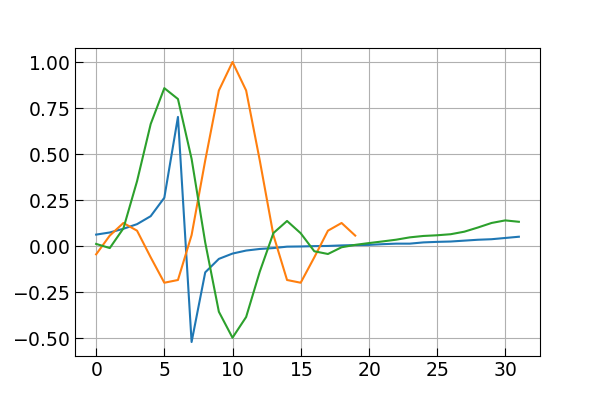

In [10]:
dt = 1/80e6
fco=4e6
wco=pi2*fco
ts = np.arange(20)*dt

lowpass = np.exp(-ts*wco)
lowpass = np.sinc((ts-dt*10)*wco)

combined = np.convolve(FIR_filter,lowpass,mode='same')

plt.figure()
plt.plot(FIR_filter)
plt.plot(lowpass)
plt.plot(combined)
plt.grid(True)

In [11]:
# How many bunches are counted
np.log(1000)/(pi2*25e-9*1e5)

439.76135932765663

In [13]:
np.exp(-2*np.pi*25e-9*1e5*63)

0.37172472474445467

# Is feedback error LF or HF noise?

In [140]:
fco = 1e6
wco = pi2*fco
dt = 25e-9

Nb = 128*32
mux=1
sigx=0.1
sigbpm=0.1

xbi = np.random.randn(Nb)*sigx 
dbpm= np.random.randn(Nb)*sigbpm
bs  = np.arange(Nb)
kicks = np.zeros(Nb)

for i in range(Nb):
    kicks[i] = np.sum(weight(bs[i]-bs,wco=wco,dt=dt,mode=2)*dbpm)

<IPython.core.display.Javascript object>


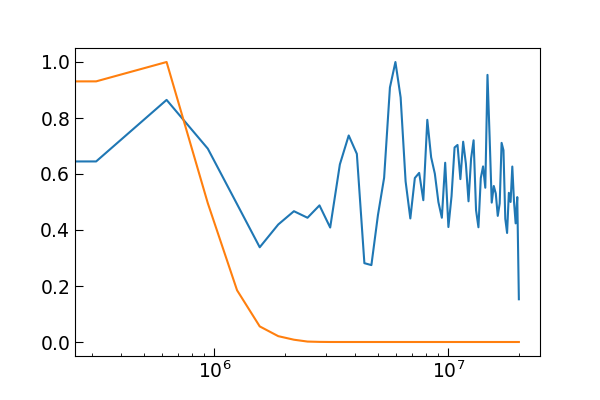

In [141]:
from scipy import signal
plt.figure()
# plt.plot(dbpm)
# plt.plot(kicks)
for xi in [dbpm,kicks]:
#     xf= np.fft.rfft(xi,axis=0,norm='ortho')#/Nx#,norm='ortho')
#     ff= np.fft.rfftfreq(Nb,d=dt)
    ff,xf=signal.welch(xi,fs=1/dt,return_onesided=True,nperseg=128*1)
    plt.semilogx(ff,np.abs(xf/np.max(xf))**2)